<a href="https://colab.research.google.com/github/lehongminhh2004/NLP/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Final Assignment: Encoder-Decoder Long Short Term Memory
## Xây dựng mô hình dịch máy Anh - Pháp


## 1. Cài đặt các thư viện cần thiết




In [1]:
print("📦 Installing dependencies...")
print("="*80)

# Install spaCy và models
!pip install -q spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

# Import thư viện
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import spacy
import random
import math
import time
import requests
import gzip
import io
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Setup completed!")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

📦 Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 92.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

✅ Setup completed!
🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 Memory: 15.83 GB


## 2. Tải MULTI30K Dataset

In [2]:
print("\n" + "="*80)
print("bước 1: TẢI MULTI30K DATASET")
print("="*80)

import gzip          # giải nén các file .gz
import io            # xử lý dữ liệu dạng bytes trong bộ nhớ
import requests      # thư viện gửi HTTP request để tải file từ GitHub

def download_multi30k():
    """
    Download dataset Multi30k từ GitHub.

    Trên GitHub, các file song ngữ (train.en, train.fr, ...) thường ở dạng nén .gz.
    Hàm này sẽ:
      1. Tải file .gz về bằng HTTP GET
      2. Giải nén trực tiếp trong bộ nhớ (không cần lưu ra đĩa)
      3. Tách nội dung thành danh sách các câu (mỗi dòng là một câu)
      4. Trả về một dict: { 'train.en': [câu1, câu2, ...], ... }
    """

    # URL gốc chứa dữ liệu Multi30k dạng raw
    base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"

    # Ánh xạ tên logic (train.en, train.fr, ...) -> tên file thật trên GitHub (.gz)
    file_mapping = {
        'train.en': 'train.en.gz',
        'train.fr': 'train.fr.gz',
        'val.en':   'val.en.gz',
        'val.fr':   'val.fr.gz',
        'test.en':  'test_2016_flickr.en.gz',
        'test.fr':  'test_2016_flickr.fr.gz'
    }

    # data sẽ chứa toàn bộ câu sau khi tải và giải nén
    # dạng: data['train.en'] = [sentence_1, sentence_2, ...]
    data = {}
    print("\nDownloading and decompressing files:")

    # Lặp qua từng file cần tải
    for key, file in file_mapping.items():
        print(f"  📄 {file}...", end=" ")
        url = base_url + file  # Ghép thành URL hoàn chỉnh

        try:
            # Gửi HTTP GET để tải file .gz
            response = requests.get(url)

            # Nếu mã trạng thái HTTP khác 200 => lỗi tải
            if response.status_code != 200:
                print(f"❌ Failed (status {response.status_code})")
                continue

            # Giải nén file .gz ngay trong bộ nhớ:
            # - io.BytesIO(response.content): biến content (bytes) thành "file ảo"
            # - gzip.open(..., 'rt', encoding='utf-8'): mở ở chế độ text (rt = read text)
            with gzip.open(io.BytesIO(response.content), 'rt', encoding='utf-8') as f:
                # Đọc toàn bộ nội dung, bỏ khoảng trắng 2 đầu, tách theo dòng => list câu
                lines = f.read().strip().split('\n')

            # Lưu vào dict với key là tên logic: 'train.en', 'train.fr', ...
            data[key] = lines
            print(f"✓ ({len(lines)} sentences)")

        except Exception as e:
            # Nếu có lỗi (mạng, giải nén, v.v.) thì in ra
            print(f"❌ Error: {str(e)}")

    return data

# Gọi hàm để tải dataset chính
raw_data = download_multi30k()

# Nếu dict rỗng => tất cả tải thất bại, thử cách dự phòng
if not raw_data:
    print("\n⚠️  Download failed! Trying alternative method...")

    def download_alternative():
        """
        Phương án dự phòng:
        - Thay vì tải file nén (.gz) thì tải trực tiếp file .en, .fr không nén.
        - Cách làm tương tự: GET nội dung, tách theo dòng.
        """
        base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
        files = {
            'train.en': 'train.en',
            'train.fr': 'train.fr',
            'val.en':   'val.en',
            'val.fr':   'val.fr',
            'test.en':  'test_2016_flickr.en',
            'test.fr':  'test_2016_flickr.fr'
        }

        data = {}
        for key, file in files.items():
            url = base_url + file
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    # Tách nội dung theo dòng, mỗi dòng là 1 câu
                    data[key] = response.text.strip().split('\n')
                    print(f"  ✓ {file}: {len(data[key])} sentences")
            except:
                # Nếu lỗi thì bỏ qua, không làm hỏng cả quá trình
                pass

        return data

    # Thử tải bằng phương án dự phòng
    raw_data = download_alternative()

# In thống kê cơ bản về số lượng câu trong từng tập
print(f"\n📊 Dataset Statistics:")
print(f"  • Train: {len(raw_data.get('train.en', [])):,} parallel sentences")
print(f"  • Val:   {len(raw_data.get('val.en', [])):,} parallel sentences")
print(f"  • Test:  {len(raw_data.get('test.en', [])):,} parallel sentences")

# Kiểm tra nhanh chất lượng dữ liệu (ví dụ: train phải có ít nhất 1000 câu)
if len(raw_data.get('train.en', [])) < 1000:
    print("\n⚠️  WARNING: Dataset seems incomplete!")
    print("  Please check if files were downloaded correctly.")
else:
    print("\n✅ Dataset downloaded successfully!")

# In thử một vài cặp câu song ngữ để kiểm tra trực quan
print(f"\n📝 Sample Data:")
try:
    # Lấy tối đa 3 câu đầu tiên của train.en / train.fr để demo
    for i in range(min(3, len(raw_data.get('train.en', [])))):
        en_sent = raw_data['train.en'][i]  # câu tiếng Anh
        fr_sent = raw_data['train.fr'][i]  # câu tiếng Pháp tương ứng

        # Nếu câu quá dài, in rút gọn cho gọn màn hình
        if len(en_sent) > 200:
            print(f"\n  [{i+1}] EN: {en_sent[:100]}... (truncated)")
        else:
            print(f"\n  [{i+1}] EN: {en_sent}")

        if len(fr_sent) > 200:
            print(f"      FR: {fr_sent[:100]}... (truncated)")
        else:
            print(f"      FR: {fr_sent}")
except Exception as e:
    # Nếu trong quá trình in sample có lỗi (thiếu key, lỗi encoding, ...) thì báo
    print(f"  ❌ Error displaying samples: {str(e)}")


bước 1: TẢI MULTI30K DATASET

  📄 train.en.gz... ✓ (29000 sentences)
  📄 train.fr.gz... ✓ (29000 sentences)
  📄 val.en.gz... ✓ (1014 sentences)
  📄 val.fr.gz... ✓ (1014 sentences)
  📄 test_2016_flickr.en.gz... ✓ (1000 sentences)
  📄 test_2016_flickr.fr.gz... ✓ (1000 sentences)

📊 Dataset Statistics:
  • Train: 29,000 parallel sentences
  • Val:   1,014 parallel sentences
  • Test:  1,000 parallel sentences

✅ Dataset downloaded successfully!

📝 Sample Data:

  [1] EN: Two young, White males are outside near many bushes.
      FR: Deux jeunes hommes blancs sont dehors près de buissons.

  [2] EN: Several men in hard hats are operating a giant pulley system.
      FR: Plusieurs hommes en casque font fonctionner un système de poulies géant.

  [3] EN: A little girl climbing into a wooden playhouse.
      FR: Une petite fille grimpe dans une maisonnette en bois.


### 3. TOKENIZATION VỚI SPACY

In [3]:
print("\n" + "="*80)
print("🔤 BƯỚC 2: TOKENIZATION VỚI SPACY")
print("="*80)

# Ở bước này, ta sẽ:
# - Load tokenizer tiếng Anh & tiếng Pháp từ spaCy
# - Định nghĩa hàm tiền xử lý (preprocess) chuỗi
# - Định nghĩa hàm tokenize cho EN và FR
# - Áp dụng tokenize cho toàn bộ dataset (train / val / test)

# Load spaCy models
print("\nLoading spaCy tokenizers...")
# Model tiếng Anh cỡ nhỏ (en_core_web_sm) dùng để tách câu thành token
spacy_en = spacy.load('en_core_web_sm')
# Model tiếng Pháp cỡ nhỏ (fr_core_news_sm) dùng để tách câu thành token
spacy_fr = spacy.load('fr_core_news_sm')
print("  ✓ English tokenizer loaded")
print("  ✓ French tokenizer loaded")

def preprocess_text(text):
    """
    Tiền xử lý text cho Machine Translation.

    Các bước thực hiện:
      - Chuẩn hóa khoảng trắng (nhiều khoảng trắng liên tiếp -> 1 khoảng trắng)
      - Chuyển toàn bộ câu thành chữ thường (lowercase)
      - GIỮ NGUYÊN:
          + Dấu câu (. , ! ? ...)
          + Dấu tiếng Pháp / accents (é, è, à, ç, ê, …)
          + Stopwords (the, a, et, le, la, ...)

    Lưu ý: Ở giai đoạn này ta chưa xóa dấu câu hay stopwords,
    vì trong dịch máy, những thông tin này có thể mang nghĩa.
    """
    # Normalize whitespace:
    # text.split() tách theo khoảng trắng (tự bỏ bớt khoảng trắng thừa),
    # " ".join(...) ghép lại bằng 1 khoảng trắng duy nhất
    text = " ".join(text.split())

    # Chuyển toàn bộ chuỗi thành chữ thường (ví dụ: "Hello World!" -> "hello world!")
    # Việc lowercase giúp giảm kích thước vocabulary (ít token khác nhau hơn)
    text = text.lower()

    return text

def tokenize_en(text):
    """
    Tokenize câu tiếng Anh với bước tiền xử lý.

    Quy trình:
      1. Gọi preprocess_text để chuẩn hóa chuỗi
      2. Dùng tokenizer của spaCy (spacy_en.tokenizer) để tách câu thành token
      3. Trả về danh sách chuỗi token (list[str])
    """
    text = preprocess_text(text)
    # spacy_en.tokenizer(text) trả về Doc object, mỗi tok là 1 token
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """
    Tokenize câu tiếng Pháp với bước tiền xử lý.

    Giữ nguyên accents tiếng Pháp như:
      - à, â, ä
      - é, è, ê, ë
      - ç, ô, ù, û, ü, ...

    Quy trình tương tự tokenize_en:
      1. Tiền xử lý (normalize, lowercase)
      2. Dùng tokenizer tiếng Pháp của spaCy
      3. Trả về list token dạng chuỗi
    """
    text = preprocess_text(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

# Tokenize toàn bộ dataset
print("\n🔄 Tokenizing datasets...")

# tqdm dùng để hiển thị progress bar khi lặp qua nhiều phần tử (cho dễ theo dõi)
# Mỗi phần tử trong raw_data['train.en'] là 1 câu (string),
# ta áp dụng tokenize_en để biến thành list token
train_en = [tokenize_en(sent) for sent in tqdm(raw_data['train.en'], desc="Train EN")]
train_fr = [tokenize_fr(sent) for sent in tqdm(raw_data['train.fr'], desc="Train FR")]

# Tương tự cho tập validation
val_en = [tokenize_en(sent) for sent in tqdm(raw_data['val.en'], desc="Val EN")]
val_fr = [tokenize_fr(sent) for sent in tqdm(raw_data['val.fr'], desc="Val FR")]

# Và cho tập test
test_en = [tokenize_en(sent) for sent in tqdm(raw_data['test.en'], desc="Test EN")]
test_fr = [tokenize_fr(sent) for sent in tqdm(raw_data['test.fr'], desc="Test FR")]

# Ví dụ: in ra 1 câu gốc và token tương ứng để kiểm tra
print(f"\n📌 Tokenization Example:")
print(f"  Original: {raw_data['train.en'][0]}")  # Câu tiếng Anh gốc (string)
print(f"  Tokens:   {train_en[0]}")              # Danh sách token sau khi tokenize (list[str])



🔤 BƯỚC 2: TOKENIZATION VỚI SPACY

Loading spaCy tokenizers...
  ✓ English tokenizer loaded
  ✓ French tokenizer loaded

🔄 Tokenizing datasets...


Train EN:   0%|          | 0/29000 [00:00<?, ?it/s]

Train FR:   0%|          | 0/29000 [00:00<?, ?it/s]

Val EN:   0%|          | 0/1014 [00:00<?, ?it/s]

Val FR:   0%|          | 0/1014 [00:00<?, ?it/s]

Test EN:   0%|          | 0/1000 [00:00<?, ?it/s]

Test FR:   0%|          | 0/1000 [00:00<?, ?it/s]


📌 Tokenization Example:
  Original: Two young, White males are outside near many bushes.
  Tokens:   ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


### 4. Xây dựng Vocabulary

In [8]:
print("\n" + "="*80)
print("📚 BƯỚC 3: XÂY DỰNG VOCABULARY")
print("="*80)

class Vocabulary:
    """
    Lớp Vocabulary: Xây dựng từ điển (vocab) từ corpus đã tokenize.

    - Nhiệm vụ:
        + Đếm tần suất xuất hiện của từng từ trong tập train
        + Giữ lại các từ có tần suất >= freq_threshold
        + Giới hạn tối đa 10,000 từ phổ biến nhất
        + Quản lý mapping:
            * itos: index -> string (từ)
            * stoi: string -> index (từ -> id)

    - Các token đặc biệt dùng trong mô hình seq2seq:
        <pad> : dùng để padding cho các câu ngắn hơn max_length
        <sos> : start of sentence (bắt đầu câu)
        <eos> : end of sentence (kết thúc câu)
        <unk> : unknown token (từ không có trong vocab)
    """

    def __init__(self, freq_threshold=2):
        """
        freq_threshold: ngưỡng tần suất.
            - Chỉ các từ có số lần xuất hiện >= freq_threshold
              mới được thêm vào vocab (tránh từ quá hiếm).
        """
        # itos (index to string): ánh xạ từ id -> token
        self.itos = {
            0: "<pad>",
            1: "<sos>",
            2: "<eos>",
            3: "<unk>"
        }

        # stoi (string to index): ánh xạ từ token -> id
        self.stoi = {
            "<pad>": 0,
            "<sos>": 1,
            "<eos>": 2,
            "<unk>": 3
        }

        # Ngưỡng tần suất tối thiểu để thêm từ vào từ điển
        self.freq_threshold = freq_threshold

    def __len__(self):
        """
        Trả về kích thước vocabulary (số lượng token khác nhau)
        bao gồm cả các token đặc biệt.
        """
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        """
        Xây dựng vocab từ danh sách câu đã tokenize (list[list[token]]).

        Các bước:
          1. Đếm tần suất xuất hiện của từng token trong toàn bộ sentence_list
          2. Lấy ra top 10,000 token phổ biến nhất
          3. Chỉ thêm những token có count >= freq_threshold vào vocab

        sentence_list: ví dụ là train_en hoặc train_fr, mỗi phần tử là 1 câu (list token).
        """
        # Counter dùng để đếm tần suất từng từ
        frequencies = Counter()
        # Bắt đầu index cho từ "bình thường" sau các token đặc biệt
        idx = 4

        # Duyệt qua từng câu trong corpus
        for sentence in sentence_list:
            # sentence là list token: ["a", "man", "is", "walking", ...]
            for word in sentence:
                frequencies[word] += 1  # tăng đếm cho token đó

        # Lấy ra top 10,000 từ phổ biến nhất (word, count)
        # Nếu số từ ít hơn 10,000 thì lấy hết
        most_common = frequencies.most_common(10000)

        # Duyệt qua các từ phổ biến nhất
        for word, count in most_common:
            # Chỉ thêm từ nếu tần suất >= freq_threshold
            if count >= self.freq_threshold:
                # Map từ -> id
                self.stoi[word] = idx
                # Map id -> từ
                self.itos[idx] = word
                # Tăng index cho từ tiếp theo
                idx += 1

    def numericalize(self, text):
        """
        Chuyển một câu (list token) thành list các chỉ số (id).

        - text: list token, ví dụ: ["a", "man", "is", "walking"]
        - Nếu token không có trong từ điển (OOV) thì dùng id của <unk>

        Trả về: list[int]
        """
        return [
            self.stoi.get(token, self.stoi["<unk>"])  # nếu không tồn tại thì lấy <unk>
            for token in text
        ]

# Xây dựng vocab cho tiếng Anh và tiếng Pháp
print("Building vocabularies...")

# freq_threshold=2: bỏ qua các từ xuất hiện 1 lần (quá hiếm)
en_vocab = Vocabulary(freq_threshold=2)
fr_vocab = Vocabulary(freq_threshold=2)

# Dùng tập train để build vocab (chuẩn: luôn build vocab từ train set)
en_vocab.build_vocabulary(train_en)
fr_vocab.build_vocabulary(train_fr)

print(f"\n📊 Vocabulary Statistics:")
print(f"  • English vocab size: {len(en_vocab):,} words")
print(f"  • French vocab size:  {len(fr_vocab):,} words")

# In ra id của các token đặc biệt để dễ kiểm tra
print(f"\n🏷️  Special Tokens:")
print(f"  • <pad>: {en_vocab.stoi['<pad>']}")
print(f"  • <sos>: {en_vocab.stoi['<sos>']}")
print(f"  • <eos>: {en_vocab.stoi['<eos>']}")
print(f"  • <unk>: {en_vocab.stoi['<unk>']}")

# Ví dụ: lấy 5 token đầu tiên của câu tiếng Anh đầu tiên
example = train_en[0][:5]
print(f"\n📝 Numericalization Example:")
print(f"  Tokens:  {example}")
print(f"  Indices: {en_vocab.numericalize(example)}")
# -> cho thấy cách câu từ dạng token được map sang id tương ứng


📚 BƯỚC 3: XÂY DỰNG VOCABULARY
Building vocabularies...

📊 Vocabulary Statistics:
  • English vocab size: 5,892 words
  • French vocab size:  6,470 words

🏷️  Special Tokens:
  • <pad>: 0
  • <sos>: 1
  • <eos>: 2
  • <unk>: 3

📝 Numericalization Example:
  Tokens:  ['two', 'young', ',', 'white', 'males']
  Indices: [16, 24, 15, 25, 774]


### 5. Dataset và Dataloader

In [9]:
print("\n" + "="*80)
print("📦 BƯỚC 4: TẠO DATASET & DATALOADER")
print("="*80)

class TranslationDataset(Dataset):
    """
    Dataset cho bài toán dịch máy (Machine Translation).

    - Mỗi phần tử (item) trong dataset là một cặp:
        (câu nguồn đã tokenize, câu đích đã tokenize)
    - Ở đây:
        + src_data: danh sách câu nguồn đã tokenize (VD: train_en)
        + trg_data: danh sách câu đích đã tokenize (VD: train_fr)
        + src_vocab: vocabulary cho ngôn ngữ nguồn (English)
        + trg_vocab: vocabulary cho ngôn ngữ đích (French)
    """

    def __init__(self, src_data, trg_data, src_vocab, trg_vocab):
        # Lưu lại dữ liệu và vocab để dùng trong __getitem__
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        """
        Trả về số lượng phần tử trong dataset.
        Ở đây giả định src_data và trg_data có cùng độ dài.
        """
        return len(self.src_data)

    def __getitem__(self, idx):
        """
        Lấy ra 1 mẫu dữ liệu tại vị trí idx.

        Quy trình:
          1. Lấy câu nguồn và câu đích dạng token (list[str])
          2. Ánh xạ từng token -> id (numericalize)
          3. Với câu đích (target), thêm <sos> ở đầu và <eos> ở cuối
          4. Trả về 2 tensor 1D: src_tensor, trg_tensor
        """

        # Câu nguồn & câu đích dạng list token
        src_text = self.src_data[idx]
        trg_text = self.trg_data[idx]

        # Numericalize câu nguồn: list token -> list id
        numericalized_src = self.src_vocab.numericalize(src_text)

        # Với target:
        #   - Thêm <sos> ở đầu câu
        #   - Thêm <eos> ở cuối câu
        numericalized_trg = (
            [self.trg_vocab.stoi["<sos>"]]          # bắt đầu câu
            + self.trg_vocab.numericalize(trg_text) # nội dung câu
            + [self.trg_vocab.stoi["<eos>"]]        # kết thúc câu
        )

        # Trả về tensor 1D (chưa padding, độ dài tùy câu)
        return torch.tensor(numericalized_src), torch.tensor(numericalized_trg)

# Lấy id của token <pad> cho source và target
SRC_PAD_IDX = en_vocab.stoi["<pad>"]
TRG_PAD_IDX = fr_vocab.stoi["<pad>"]

def collate_fn(batch):
    """
    Hàm collate_fn dùng cho DataLoader để gộp nhiều sample thành 1 batch.

    Nhiệm vụ:
      - Nhận vào: batch = list các (src_tensor, trg_tensor) có độ dài khác nhau
      - Thực hiện padding cho tất cả src và trg về cùng độ dài (trong batch)
      - Trả về:
          src_batch: tensor kích thước (batch_size, max_src_len)
          trg_batch: tensor kích thước (batch_size, max_trg_len)

    Lưu ý:
      - padding_value: dùng SRC_PAD_IDX / TRG_PAD_IDX để padding đúng token <pad>
      - batch_first=True: shape sẽ là (batch_size, seq_len)
    """
    src_batch, trg_batch = [], []

    # Tách riêng danh sách src và trg
    for src, trg in batch:
        src_batch.append(src)
        trg_batch.append(trg)

    # pad_sequence: tự động thêm padding ở cuối cho các câu ngắn hơn
    # sao cho tất cả có cùng độ dài theo chiều seq_len
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX, batch_first=True)

    return src_batch, trg_batch

# -------------------------
# Tạo Dataset & DataLoader
# -------------------------

BATCH_SIZE = 64  # số câu trong mỗi batch

# Tạo dataset cho train/val/test
#   - train_en, train_fr: list[list token]
#   - en_vocab, fr_vocab: vocabulary tương ứng
train_dataset = TranslationDataset(train_en, train_fr, en_vocab, fr_vocab)
val_dataset   = TranslationDataset(val_en,  val_fr,  en_vocab, fr_vocab)
test_dataset  = TranslationDataset(test_en, test_fr, en_vocab, fr_vocab)

# Tạo DataLoader
#   - shuffle=True cho train để mô hình không học theo thứ tự cố định
#   - collate_fn=collate_fn để thực hiện padding mỗi batch
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"✅ Dataloaders created!")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val  batches:  {len(val_loader)}")
print(f"  • Test batches:  {len(test_loader)}")

# Lấy thử 1 batch để kiểm tra kích thước
src_sample, trg_sample = next(iter(train_loader))
print(f"\n📊 Sample Batch Shapes:")
print(f"  • Source: {src_sample.shape}")  # (batch_size, max_src_len_trong_batch)
print(f"  • Target: {trg_sample.shape}")  # (batch_size, max_trg_len_trong_batch)



📦 BƯỚC 4: TẠO DATASET & DATALOADER
✅ Dataloaders created!
  • Batch size: 64
  • Train batches: 454
  • Val  batches:  16
  • Test batches:  16

📊 Sample Batch Shapes:
  • Source: torch.Size([64, 24])
  • Target: torch.Size([64, 28])


### 6. Model
- 6.1 Encoder Model

In [11]:
print("\n" + "="*80)
print("🏗️  BƯỚC 6.1: XÂY DỰNG ENCODER")
print("="*80)

class Encoder(nn.Module):
    """
    LSTM Encoder cho bài toán dịch máy (seq2seq).

    Ý tưởng:
      - Nhận vào chuỗi nguồn (source sentence) đã được mã hóa thành id
      - Bước 1: Tra embedding cho từng token
      - Bước 2: Cho chuỗi embedding đi qua LSTM nhiều layer
      - Bước 3: Lấy ra (hidden, cell) cuối cùng của LSTM
                => Đây chính là "context vector" tóm tắt toàn bộ câu nguồn.

    Công thức LSTM:
        (h_t, c_t) = LSTM(embed(x_t), (h_{t-1}, c_{t-1}))

    Ở cuối câu (t = n), ta thu được:
        Context vector = (h_n, c_n)
    và sẽ truyền (h_n, c_n) này sang Decoder để khởi tạo trạng thái ban đầu.
    """

    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        """
        input_dim  : kích thước vocab của ngôn ngữ nguồn (số lượng từ khác nhau)
        emb_dim    : kích thước vector embedding cho mỗi token (vd: 256, 512)
        hidden_dim : kích thước hidden state của LSTM
        n_layers   : số layer LSTM chồng lên nhau (stacked LSTM)
        dropout    : tỉ lệ dropout áp dụng giữa các layer LSTM (nếu n_layers > 1)
        """
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Lớp embedding:
        #   - input_dim: số token khác nhau (vocab size)
        #   - emb_dim: chiều vector embedding
        #   - padding_idx=SRC_PAD_IDX: embedding của <pad> trong source sẽ được xử lý đặc biệt
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=SRC_PAD_IDX)

        # LSTM:
        #   - input_size  = emb_dim  (đầu vào mỗi bước thời gian là 1 vector embedding)
        #   - hidden_size = hidden_dim
        #   - num_layers  = n_layers (stacked LSTM)
        #   - dropout     = chỉ dùng giữa các layer nếu n_layers > 1
        #   - batch_first=True: input/output có dạng (batch_size, seq_len, feature_dim)
        self.lstm = nn.LSTM(
            emb_dim,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,  # nếu chỉ 1 layer thì không dùng dropout nội bộ
            batch_first=True
        )

        # Dropout áp dụng lên embedding (hoặc feature) trước khi đưa vào LSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        """
        src: tensor chứa batch câu nguồn
             shape: [batch_size, src_len]
             (mỗi phần tử là id của 1 token)

        Quy trình:
          1. src -> embedding: [batch_size, src_len, emb_dim]
          2. áp dụng dropout
          3. đưa qua LSTM -> nhận outputs (tất cả bước thời gian) và (hidden, cell) cuối cùng
          4. Trả về (hidden, cell) để dùng làm context cho Decoder
        """

        # Bước 1: Embedding + Dropout
        # self.embedding(src): map id -> vector embedding
        embedded = self.dropout(self.embedding(src))
        # embedded shape: [batch_size, src_len, emb_dim]

        # Bước 2: Cho qua LSTM
        # outputs: toàn bộ hidden states trên mỗi bước thời gian (thường không dùng trong mô hình context vector cố định)
        # hidden, cell: hidden state và cell state tại bước cuối cùng cho mỗi layer
        outputs, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n_layers, batch_size, hidden_dim]
        # cell   shape: [n_layers, batch_size, hidden_dim]

        # Ở mô hình Encoder-Decoder dùng context vector cố định:
        #   - Ta không dùng outputs (từng bước) mà chỉ dùng (hidden, cell) cuối cùng
        #   - (hidden, cell) này sẽ được truyền sang Decoder để khởi tạo trạng thái ban đầu
        return hidden, cell

print("✅ Encoder class defined!")
print("""
📐 Architecture:
   Input (token ids) → Embedding → Dropout → LSTM → Context Vector

   Context Vector = (h_n, c_n):
     • h_n: hidden state cuối cùng (tóm tắt toàn bộ câu nguồn)
     • c_n: cell state cuối cùng
     • Hai tensor này được truyền sang Decoder để khởi tạo trạng thái ban đầu.
""")



🏗️  BƯỚC 6.1: XÂY DỰNG ENCODER
✅ Encoder class defined!

📐 Architecture:
   Input (token ids) → Embedding → Dropout → LSTM → Context Vector

   Context Vector = (h_n, c_n):
     • h_n: hidden state cuối cùng (tóm tắt toàn bộ câu nguồn)
     • c_n: cell state cuối cùng
     • Hai tensor này được truyền sang Decoder để khởi tạo trạng thái ban đầu.



- 6.2 Decoder Model

In [12]:
print("\n" + "="*80)
print("🏗️  BƯỚC 6.2: XÂY DỰNG DECODER")
print("="*80)

class Decoder(nn.Module):
    """
    LSTM Decoder cho mô hình Encoder–Decoder.

    Ý tưởng:
      - Ở mỗi thời điểm t, Decoder nhận:
          + input: token y_{t-1} (token trước đó trong câu đích)
          + (h_{t-1}, c_{t-1}): hidden & cell state từ bước trước
      - Sau đó:
          1. Tra embedding cho y_{t-1}
          2. Cho embedding qua LSTM với (h_{t-1}, c_{t-1})
          3. Lấy hidden state h_t tại thời điểm hiện tại
          4. Qua Linear + Softmax để suy ra phân phối xác suất p(y_t)

    Công thức:
        (h_t, c_t) = LSTM(embed(y_{t-1}), (h_{t-1}, c_{t-1}))
        p(y_t)     = softmax(Linear(h_t))

    Lưu ý:
      - Ở đây Softmax không được gọi trực tiếp trong forward()
        vì ta dùng CrossEntropyLoss, nó đã gồm luôn log_softmax bên trong.
    """

    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        """
        output_dim : kích thước vocab của ngôn ngữ đích (French)
        emb_dim    : kích thước vector embedding cho token đích
        hidden_dim : kích thước hidden state của LSTM
        n_layers   : số layer LSTM (stacked LSTM)
        dropout    : tỉ lệ dropout giữa các layer LSTM (nếu n_layers > 1)
        """
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding cho token đích:
        #   - output_dim: vocab size của French
        #   - emb_dim: chiều vector embedding
        #   - padding_idx=TRG_PAD_IDX: id của <pad> trong target
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=TRG_PAD_IDX)

        # LSTM Decoder:
        #   - input_size  = emb_dim
        #   - hidden_size = hidden_dim
        #   - num_layers  = n_layers
        #   - dropout: chỉ dùng nếu n_layers > 1
        #   - batch_first=True: input/output có dạng (batch_size, seq_len, feature_dim)
        self.lstm = nn.LSTM(
            emb_dim,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Linear layer:
        #   - Nhận hidden state tại thời điểm hiện tại (kích thước hidden_dim)
        #   - Xuất ra vector kích thước output_dim (logits cho mỗi token trong vocab)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Dropout áp dụng lên embedding trước khi đưa vào LSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        """
        Forward một bước thời gian (1 time step) của Decoder.

        input : [batch_size]
            - Mỗi phần tử là id của token đích hiện tại (y_{t-1}).
            - Khi t=1, input thường là token <sos>.
        hidden: [n_layers, batch_size, hidden_dim]
        cell  : [n_layers, batch_size, hidden_dim]

        Trả về:
          - prediction: [batch_size, output_dim] (logits cho token y_t)
          - hidden    : hidden state mới [n_layers, batch_size, hidden_dim]
          - cell      : cell state mới [n_layers, batch_size, hidden_dim]
        """

        # Hiện tại input có shape: [batch_size]
        # LSTM yêu cầu input có shape [batch_size, seq_len, emb_dim]
        # mà ở đây seq_len = 1 (mỗi lần xử lý 1 token),
        # nên ta unsqueeze(1) để thêm chiều seq_len.
        input = input.unsqueeze(1)  # [batch_size, 1]

        # Embedding + Dropout cho token y_{t-1}
        embedded = self.dropout(self.embedding(input))
        # embedded: [batch_size, 1, emb_dim]

        # Đưa qua LSTM cùng với (hidden, cell) từ bước trước
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: [batch_size, 1, hidden_dim]
        # hidden: [n_layers, batch_size, hidden_dim]
        # cell  : [n_layers, batch_size, hidden_dim]

        # Ta chỉ quan tâm hidden state ở bước hiện tại (seq_len = 1),
        # nên có thể squeeze chiều seq_len đi.
        prediction = self.fc_out(output.squeeze(1))
        # output.squeeze(1): [batch_size, hidden_dim]
        # prediction:        [batch_size, output_dim]
        #   -> đây là logits trước softmax, dùng cho CrossEntropyLoss

        # Trả về:
        #   - prediction: dùng để tính loss / chọn token tiếp theo
        #   - hidden, cell: dùng trong bước decoder tiếp theo
        return prediction, hidden, cell

print("✅ Decoder class defined!")
print("""
📐 Architecture:
   Previous token (y_{t-1}) → Embedding → Dropout → LSTM → Linear → (Softmax trong loss)

   Teacher Forcing (ratio=0.5):
     • 50%: sử dụng ground truth token từ câu đích làm input cho bước tiếp theo
     • 50%: sử dụng chính predicted token (argmax) từ mô hình làm input
     → Giúp mô hình vừa học tốt, vừa dần làm quen với lỗi của chính nó khi suy diễn.
""")



🏗️  BƯỚC 6.2: XÂY DỰNG DECODER
✅ Decoder class defined!

📐 Architecture:
   Previous token (y_{t-1}) → Embedding → Dropout → LSTM → Linear → (Softmax trong loss)

   Teacher Forcing (ratio=0.5):
     • 50%: sử dụng ground truth token từ câu đích làm input cho bước tiếp theo
     • 50%: sử dụng chính predicted token (argmax) từ mô hình làm input
     → Giúp mô hình vừa học tốt, vừa dần làm quen với lỗi của chính nó khi suy diễn.



- 6.3 Seq2Seq Model

In [13]:
print("\n" + "="*80)
print("🏗️  BƯỚC 6.3: KẾT HỢP ENCODER-DECODER")
print("="*80)

class Seq2Seq(nn.Module):
    """
    Mô hình Seq2Seq dựa trên Encoder–Decoder với context vector cố định.

    Ý tưởng tổng thể:
      1. Encoder đọc toàn bộ câu nguồn (English) → tạo ra context vector (hidden, cell)
      2. Decoder dùng context vector này để sinh câu đích (French) từng token một
      3. Trong quá trình train, ta dùng Teacher Forcing với tỉ lệ nhất định.

    forward():
      - Nhận:
          src: batch câu nguồn đã được padding, shape [batch_size, src_len]
          trg: batch câu đích (có <sos>, <eos>, padding), shape [batch_size, trg_len]
      - Trả:
          outputs: tensor chứa logits cho từng bước thời gian,
                   shape [batch_size, trg_len, trg_vocab_size]
    """

    def __init__(self, encoder, decoder, device):
        """
        encoder : instance của lớp Encoder
        decoder : instance của lớp Decoder
        device  : 'cuda' hoặc 'cpu'
        """
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Thực hiện 1 forward pass trên cả câu (chuỗi) cho toàn bộ batch.

        src: [batch_size, src_len]
        trg: [batch_size, trg_len]
             - trg[:, 0] thường là token <sos>
             - trg[:, 1:] là các token của câu đích dịch sang French
        teacher_forcing_ratio:
             - Xác suất dùng ground truth token ở thời điểm t-1 làm input
               cho Decoder ở thời điểm t.
             - Ví dụ 0.5 = 50% dùng ground truth, 50% dùng token mô hình dự đoán.
        """

        batch_size = src.shape[0]       # số câu trong batch
        trg_len = trg.shape[1]         # độ dài tối đa của câu đích trong batch
        trg_vocab_size = self.decoder.output_dim  # kích thước vocab tiếng Pháp

        # Khởi tạo tensor chứa tất cả output logits:
        #   shape: [batch_size, trg_len, trg_vocab_size]
        #   - outputs[:, t, :] = logits cho tất cả token vocab tại timestep t
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # 1️⃣ ENCODER: Mã hóa toàn bộ câu nguồn → lấy context vector (hidden, cell)
        #    hidden, cell: [n_layers, batch_size, hidden_dim]
        hidden, cell = self.encoder(src)

        # 2️⃣ DECODER: Bắt đầu với token đầu tiên của câu đích (thường là <sos>)
        # trg[:, 0]: [batch_size] → mỗi phần tử là id của <sos>
        input = trg[:, 0]

        # 3️⃣ Lặp qua từng timestep t của câu đích
        #     - t = 0: là <sos> (đã dùng làm input ban đầu)
        #     - Bắt đầu từ t = 1 để dự đoán y_1, y_2, ..., y_{trg_len-1}
        for t in range(1, trg_len):
            # Gọi Decoder 1 bước:
            #   input: [batch_size]
            #   hidden, cell: trạng thái từ bước trước
            # output: [batch_size, trg_vocab_size] (logits cho token tại timestep t)
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Lưu logits cho timestep t vào tensor outputs
            outputs[:, t, :] = output

            # 4️⃣ Teacher Forcing:
            #   - teacher_force = True  với xác suất teacher_forcing_ratio
            #   - Nếu True:  dùng token ground truth làm input tiếp theo
            #   - Nếu False: dùng token mà mô hình dự đoán (argmax)
            teacher_force = random.random() < teacher_forcing_ratio

            # top1: token có xác suất cao nhất tại timestep t
            #       shape: [batch_size]
            top1 = output.argmax(1)

            # Quyết định input cho timestep tiếp theo:
            #   - trg[:, t] là token ground truth tại timestep t
            input = trg[:, t] if teacher_force else top1

        # Trả về toàn bộ logits cho cả câu (tất cả timestep)
        return outputs

# --------------------------
# Thiết lập Hyperparameters
# --------------------------

# Kích thước vocab:
#   - INPUT_DIM: số lượng token trong từ điển tiếng Anh
#   - OUTPUT_DIM: số lượng token trong từ điển tiếng Pháp
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)

# Theo khuyến nghị đề bài:
EMBEDDING_DIM = 256   # hoặc 512, ở đây chọn 256 cho nhanh
HIDDEN_DIM = 512      # kích thước hidden state của LSTM
N_LAYERS = 2          # số layer LSTM (stacked)
DROPOUT = 0.5         # dropout tương đối cao để giảm overfitting
TEACHER_FORCING_RATIO = 0.5  # 50% dùng teacher forcing

# Khởi tạo Encoder, Decoder và mô hình Seq2Seq
encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

# Hàm đếm số lượng tham số trainable trong mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Seq2Seq model initialized!")
print(f"\n📊 Model Statistics:")
print(f"  • Total parameters: {count_parameters(model):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder):,}")

print(f"\n⚙️  Hyperparameters:")
print(f"  • Hidden size:         {HIDDEN_DIM}")
print(f"  • Embedding dim:       {EMBEDDING_DIM}")
print(f"  • LSTM layers:         {N_LAYERS}")
print(f"  • Dropout:             {DROPOUT}")
print(f"  • Teacher forcing:     {TEACHER_FORCING_RATIO}")



🏗️  BƯỚC 6.3: KẾT HỢP ENCODER-DECODER
✅ Seq2Seq model initialized!

📊 Model Statistics:
  • Total parameters: 13,840,198
  • Encoder params:   5,186,560
  • Decoder params:   8,653,638

⚙️  Hyperparameters:
  • Hidden size:         512
  • Embedding dim:       256
  • LSTM layers:         2
  • Dropout:             0.5
  • Teacher forcing:     0.5


### 7. Training Function

In [14]:
print("\n" + "="*80)
print("🎯 BƯỚC 7: ĐỊNH NGHĨA HÀM TRAINING")
print("="*80)

def train_epoch(model, iterator, optimizer, criterion, clip, device):
    """
    Train mô hình trên *một* epoch.

    Tham số:
      - model     : mô hình Seq2Seq (Encoder-Decoder)
      - iterator  : DataLoader của tập train (trả về (src, trg) theo batch)
      - optimizer : Adam (hoặc optimizer khác)
      - criterion : hàm loss (CrossEntropyLoss)
      - clip      : ngưỡng gradient clipping (vd: 1.0)
      - device    : 'cuda' hoặc 'cpu'

    Trả về:
      - epoch_loss: loss trung bình trên tất cả batch trong 1 epoch
    """
    # Đặt mô hình ở chế độ train (bật dropout, batchnorm ở chế độ training)
    model.train()
    epoch_loss = 0  # dùng để cộng dồn loss từng batch

    # Duyệt qua từng batch (src, trg) trong iterator
    for src, trg in tqdm(iterator, desc="Training", leave=False):
        # Đưa dữ liệu lên GPU/CPU tương ứng
        src = src.to(device)  # src: [batch_size, src_len]
        trg = trg.to(device)  # trg: [batch_size, trg_len]

        # Xóa các gradient cũ trước khi backward
        optimizer.zero_grad()

        # Forward toàn bộ batch qua mô hình
        # output: [batch_size, trg_len, trg_vocab_size]
        output = model(src, trg, teacher_forcing_ratio=TEACHER_FORCING_RATIO)

        # Lấy kích thước vocab của target (số lớp trong softmax)
        output_dim = output.shape[-1]  # trg_vocab_size

        # Bỏ thời điểm t=0 (thường là vị trí tương ứng <sos>),
        # chỉ tính loss từ t=1..trg_len-1
        #  - output[:, 1:, :] : [batch_size, trg_len-1, trg_vocab_size]
        #  - trg[:, 1:]       : [batch_size, trg_len-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        # reshape thành [batch_size * (trg_len-1), trg_vocab_size]
        # phù hợp với CrossEntropyLoss: (N, C)

        trg = trg[:, 1:].reshape(-1)
        # reshape thành [batch_size * (trg_len-1)]
        # phù hợp với CrossEntropyLoss: (N,)

        # Tính loss cross-entropy giữa logits (output) và nhãn đúng (trg)
        loss = criterion(output, trg)

        # Lan truyền ngược gradient
        loss.backward()

        # Gradient clipping để tránh hiện tượng gradient explosion
        # Nếu norm gradient > clip → scale xuống
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Cập nhật tham số mô hình
        optimizer.step()

        # Cộng dồn loss (dạng scalar)
        epoch_loss += loss.item()

    # Trả về loss trung bình trên toàn bộ batch
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion, device):
    """
    Đánh giá (evaluate) mô hình trên tập validation/test.

    Điểm khác so với train_epoch:
      - model.eval(): tắt dropout, batchnorm ở chế độ eval
      - with torch.no_grad(): không tính gradient (tiết kiệm bộ nhớ, nhanh hơn)
      - teacher_forcing_ratio = 0 khi evaluate
        → mô hình tự sử dụng token dự đoán ở bước trước làm input cho bước sau.
    """
    model.eval()       # bật chế độ eval
    epoch_loss = 0

    # Không tính gradient trong quá trình evaluate
    with torch.no_grad():
        for src, trg in tqdm(iterator, desc="Evaluating", leave=False):
            src = src.to(device)
            trg = trg.to(device)

            # Trong đánh giá không dùng teacher forcing
            output = model(src, trg, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]

            # Tương tự như train: bỏ vị trí t=0
            output = output[:, 1:, :].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# ---------------------------
# Khai báo Loss, Optimizer, Scheduler
# ---------------------------

# Lấy chỉ số (id) của token <pad> trong target để bỏ qua khi tính loss
PAD_IDX = fr_vocab.stoi["<pad>"]

# CrossEntropyLoss:
#   - ignore_index=PAD_IDX: các vị trí là <pad> sẽ không góp phần vào loss
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Optimizer Adam với learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler giảm learning rate khi val_loss không cải thiện:
#   - mode='min'  : theo dõi giá trị nhỏ nhất (loss)
#   - factor=0.5  : mỗi lần giảm, lr_new = 0.5 * lr_old
#   - patience=2  : nếu 2 epoch liên tiếp không giảm val_loss thì giảm lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("✅ Training functions defined!")
print(f"\n⚙️  Training Configuration:")
print(f"  • Loss:         CrossEntropyLoss(ignore_index={PAD_IDX})")
print(f"  • Optimizer:    Adam(lr=0.001)")
print(f"  • Scheduler:    ReduceLROnPlateau")
print(f"  • Gradient clip: 1.0")



🎯 BƯỚC 7: ĐỊNH NGHĨA HÀM TRAINING
✅ Training functions defined!

⚙️  Training Configuration:
  • Loss:         CrossEntropyLoss(ignore_index=0)
  • Optimizer:    Adam(lr=0.001)
  • Scheduler:    ReduceLROnPlateau
  • Gradient clip: 1.0


### 8. Training

In [15]:
print("\n" + "="*80)
print("🚀 BƯỚC 8: BẮT ĐẦU TRAINING")
print("="*80)

# Số epoch tối đa để train
N_EPOCHS = 20

# Ngưỡng gradient clipping
CLIP = 1

# Số epoch cho cơ chế early stopping:
#   - Nếu val_loss không cải thiện liên tiếp PATIENCE lần → dừng train
PATIENCE = 3

# Giá trị best_valid_loss ban đầu đặt là +∞ (để lần đầu chắc chắn nhỏ hơn)
best_valid_loss = float('inf')

# Đếm số epoch liên tiếp mà val_loss không giảm
patience_counter = 0

# Danh sách lưu lại train_loss và val_loss theo từng epoch
# (dùng để vẽ learning curve / báo cáo sau)
train_losses = []
val_losses = []

print(f"\n⏰ Training {N_EPOCHS} epochs...")
print(f"📊 Early stopping patience: {PATIENCE}")
print("="*80)

# Vòng lặp qua từng epoch
for epoch in range(N_EPOCHS):
    # Ghi nhận thời gian bắt đầu epoch
    start_time = time.time()

    # Train trên tập train (1 epoch)
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, device)

    # Evaluate trên tập validation
    valid_loss = evaluate(model, val_loader, criterion, device)

    # Tính thời gian kết thúc epoch
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    # divmod: trả về (phút, giây) từ tổng số giây

    # Lưu lại loss để sau này vẽ biểu đồ train/val loss
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    # Cập nhật scheduler:
    #   - ReduceLROnPlateau sẽ nhìn vào valid_loss
    #   - Nếu valid_loss không giảm sau một số epoch (patience của scheduler)
    #     thì tự động giảm learning rate
    scheduler.step(valid_loss)

    # In thông tin cho epoch hiện tại
    print(f'\n📅 Epoch: {epoch+1:02}/{N_EPOCHS} | ⏱️  Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'   📉 Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}')
    print(f'   📉 Val Loss:   {valid_loss:.3f} | PPL: {math.exp(valid_loss):7.3f}')
    # PPL (Perplexity) = e^(loss) → thước đo phổ biến trong NLP
    #   - PPL càng thấp → mô hình càng tốt

    # 🔍 Kiểm tra xem val_loss có cải thiện không
    if valid_loss < best_valid_loss:
        # Nếu tốt hơn best hiện tại → cập nhật best
        best_valid_loss = valid_loss
        patience_counter = 0  # reset counter vì loss đã cải thiện

        # Lưu lại trọng số mô hình tốt nhất
        torch.save(model.state_dict(), 'best_model.pth')
        print('   ✅ Best model saved!')
    else:
        # Nếu không cải thiện → tăng patience_counter
        patience_counter += 1
        print(f'   ⏳ Patience: {patience_counter}/{PATIENCE}')

    # ⏹️  Early Stopping:
    #   - Nếu patience_counter >= PATIENCE → dừng sớm để tránh overfitting,
    #     và không lãng phí thời gian train thêm.
    if patience_counter >= PATIENCE:
        print(f'\n⚠️  Early stopping at epoch {epoch+1}')
        break

print("\n" + "="*80)
print("✅ Training completed!")


🚀 BƯỚC 8: BẮT ĐẦU TRAINING

⏰ Training 20 epochs...
📊 Early stopping patience: 3


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 01/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 4.850 | PPL: 127.734
   📉 Val Loss:   4.831 | PPL: 125.277
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 02/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 4.095 | PPL:  60.010
   📉 Val Loss:   4.596 | PPL:  99.119
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 03/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 3.698 | PPL:  40.370
   📉 Val Loss:   4.309 | PPL:  74.339
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 04/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 3.422 | PPL:  30.625
   📉 Val Loss:   4.183 | PPL:  65.565
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 05/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 3.221 | PPL:  25.058
   📉 Val Loss:   3.959 | PPL:  52.431
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 06/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 3.038 | PPL:  20.873
   📉 Val Loss:   3.932 | PPL:  51.006
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 07/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.883 | PPL:  17.874
   📉 Val Loss:   3.835 | PPL:  46.272
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 08/20 | ⏱️  Time: 0m 56s
   📉 Train Loss: 2.779 | PPL:  16.103
   📉 Val Loss:   3.765 | PPL:  43.157
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 09/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.674 | PPL:  14.494
   📉 Val Loss:   3.754 | PPL:  42.703
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 10/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.566 | PPL:  13.019
   📉 Val Loss:   3.678 | PPL:  39.576
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 11/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.483 | PPL:  11.981
   📉 Val Loss:   3.592 | PPL:  36.297
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 12/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.400 | PPL:  11.018
   📉 Val Loss:   3.577 | PPL:  35.764
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 13/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.318 | PPL:  10.160
   📉 Val Loss:   3.590 | PPL:  36.245
   ⏳ Patience: 1/3


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 14/20 | ⏱️  Time: 0m 58s
   📉 Train Loss: 2.225 | PPL:   9.256
   📉 Val Loss:   3.581 | PPL:  35.898
   ⏳ Patience: 2/3


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 15/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.181 | PPL:   8.856
   📉 Val Loss:   3.549 | PPL:  34.764
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 16/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.099 | PPL:   8.157
   📉 Val Loss:   3.566 | PPL:  35.383
   ⏳ Patience: 1/3


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 17/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 2.064 | PPL:   7.879
   📉 Val Loss:   3.498 | PPL:  33.047
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 18/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 1.989 | PPL:   7.308
   📉 Val Loss:   3.523 | PPL:  33.880
   ⏳ Patience: 1/3


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 19/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 1.929 | PPL:   6.880
   📉 Val Loss:   3.472 | PPL:  32.200
   ✅ Best model saved!


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


📅 Epoch: 20/20 | ⏱️  Time: 0m 57s
   📉 Train Loss: 1.885 | PPL:   6.588
   📉 Val Loss:   3.569 | PPL:  35.490
   ⏳ Patience: 1/3

✅ Training completed!


### 9. Vẽ đường training


📊 BƯỚC 9: TRỰC QUAN HOÁ BIỂU ĐỒ TRAN/VAL LOSS


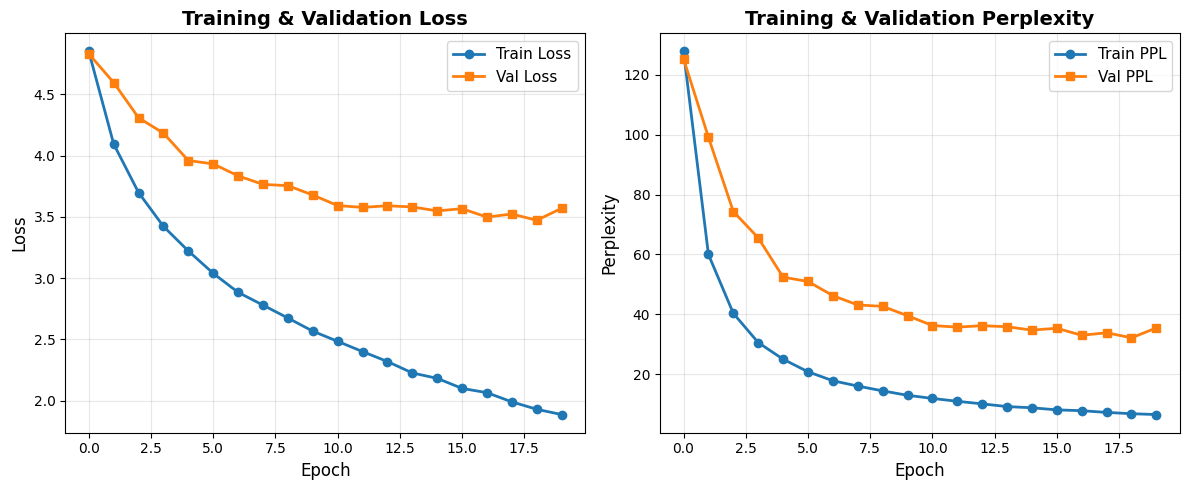

✅ Training curves saved!


In [16]:
print("\n" + "="*80)
print("📊 BƯỚC 9: TRỰC QUAN HOÁ BIỂU ĐỒ TRAN/VAL LOSS")
print("="*80)

# Lưu ý:
#   - Đảm bảo bạn đã import:
#       import matplotlib.pyplot as plt
#       import math
#   - train_losses, val_losses đã được điền trong quá trình training (Bước 8)

# Tạo một figure với kích thước 12 (rộng) x 5 (cao) inch
plt.figure(figsize=(12, 5))

# ----------------------------
# Biểu đồ 1: Training & Val Loss
# ----------------------------
plt.subplot(1, 2, 1)  # chia figure thành 1 hàng 2 cột, chọn subplot thứ 1

# Vẽ đường biểu diễn Train Loss theo epoch
plt.plot(
    train_losses,
    label='Train Loss',
    marker='o',      # đánh dấu mỗi điểm bằng hình tròn
    linewidth=2      # độ dày đường
)

# Vẽ đường biểu diễn Validation Loss theo epoch
plt.plot(
    val_losses,
    label='Val Loss',
    marker='s',      # đánh dấu mỗi điểm bằng hình vuông
    linewidth=2
)

plt.xlabel('Epoch', fontsize=12)  # nhãn trục X
plt.ylabel('Loss', fontsize=12)   # nhãn trục Y
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')  # tiêu đề
plt.legend(fontsize=11)           # hiển thị chú thích (Train/Val)
plt.grid(True, alpha=0.3)         # bật lưới nhẹ để dễ đọc

# ----------------------------
# Biểu đồ 2: Training & Val Perplexity
# ----------------------------
plt.subplot(1, 2, 2)  # chọn subplot thứ 2 (trong 1 hàng 2 cột)

# Perplexity = exp(loss)
#   - PPL là thước đo phổ biến trong NLP
#   - PPL thấp hơn -> mô hình tốt hơn
train_ppl = [math.exp(loss) for loss in train_losses]
val_ppl   = [math.exp(loss) for loss in val_losses]

# Vẽ đường Train PPL
plt.plot(
    train_ppl,
    label='Train PPL',
    marker='o',
    linewidth=2
)

# Vẽ đường Val PPL
plt.plot(
    val_ppl,
    label='Val PPL',
    marker='s',
    linewidth=2
)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Training & Validation Perplexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# sắp xếp layout cho gọn, tránh label/tiêu đề bị chồng lấn
plt.tight_layout()

# Lưu hình training curve xuống file PNG
#   - dpi=150: độ phân giải
#   - bbox_inches='tight': cắt sát viền nội dung
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')

# Hiển thị figure trên notebook
plt.show()

print("✅ Training curves saved!")


### 10. Đánh giá mô hình trên tập Test

In [18]:
print("\n" + "="*80)
print("📊 BƯỚC 10: ĐÁNH GIÁ TRÊN TEST SET")
print("="*80)

# ---------------------------
# 1️⃣ Load lại mô hình tốt nhất
# ---------------------------
# Ở bước training (Bước 8), mỗi khi val_loss tốt hơn,
# ta đã lưu trọng số mô hình vào file 'best_model.pth'.
# Tại đây, ta load lại trọng số đó để đánh giá trên test set.
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint)
model.to(device)

# ---------------------------
# 2️⃣ Đánh giá trên tập test
# ---------------------------
# Sử dụng lại hàm evaluate đã định nghĩa ở Bước 7.
#   - Không dùng teacher forcing (ratio=0)
#   - Không tính gradient (trong hàm evaluate đã có torch.no_grad())
test_loss = evaluate(model, test_loader, criterion, device)

# ---------------------------
# 3️⃣ In kết quả
# ---------------------------
print(f"\n🎯 Test Results:")
print(f"  • Test Loss: {test_loss:.3f}")
print(f"  • Test PPL:  {math.exp(test_loss):.3f}")
#   - Test Loss: cross-entropy trung bình trên toàn bộ tập test
#   - Test PPL (Perplexity): e^(loss), thước đo mức độ "bối rối" của mô hình
#       + PPL càng thấp → mô hình càng dự đoán tốt chuỗi token trên test set



📊 BƯỚC 10: ĐÁNH GIÁ TRÊN TEST SET


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


🎯 Test Results:
  • Test Loss: 3.342
  • Test PPL:  28.263


### 11. Hàm dịch

In [19]:
print("\n" + "="*80)
print("🔄 BƯỚC 11: INFERENCE - HÀM DỊCH")
print("="*80)

def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    """
    Dịch một câu từ tiếng Anh sang tiếng Pháp bằng mô hình Seq2Seq đã train.

    Cách suy diễn (decoding):
      - Sử dụng Greedy Decoding:
          + Ở mỗi bước, chọn token có xác suất cao nhất (argmax) làm đầu ra.
          + Token đó đồng thời trở thành input cho bước tiếp theo.
      - Dừng lại khi:
          + Sinh ra token <eos>, hoặc
          + Đạt đến độ dài tối đa max_len.

    Tham số:
      - model     : mô hình Seq2Seq (Encoder + Decoder)
      - sentence  : câu nguồn tiếng Anh (string) hoặc list token
      - src_vocab : vocabulary tiếng Anh (source)
      - trg_vocab : vocabulary tiếng Pháp (target)
      - device    : 'cuda' hoặc 'cpu'
      - max_len   : độ dài tối đa của câu dịch sinh ra

    Trả về:
      - trg_tokens[1:-1]: danh sách token tiếng Pháp, đã loại bỏ <sos> và <eos>
    """
    # Chuyển mô hình sang chế độ eval: tắt dropout, batchnorm ở mode infer
    model.eval()

    # -------------------------
    # 1️⃣ Tokenize câu tiếng Anh đầu vào
    # -------------------------
    if isinstance(sentence, str):
        # Nếu sentence là string, ta dùng hàm tokenize_en đã định nghĩa trước đó
        tokens = tokenize_en(sentence)
    else:
        # Nếu đã là list token sẵn thì dùng trực tiếp
        tokens = sentence

    # -------------------------
    # 2️⃣ Numericalize câu nguồn (EN) → chuỗi id
    # -------------------------
    numericalized = src_vocab.numericalize(tokens)
    # numericalized: list[int] có độ dài = số token trong câu nguồn

    # Thêm chiều batch bằng unsqueeze(0) để thành tensor shape: [1, src_len]
    src_tensor = torch.LongTensor(numericalized).unsqueeze(0).to(device)

    # -------------------------
    # 3️⃣ ENCODER: lấy context vector (hidden, cell)
    # -------------------------
    with torch.no_grad():  # không cần tính gradient khi suy diễn
        hidden, cell = model.encoder(src_tensor)
        # hidden, cell: [n_layers, batch_size=1, hidden_dim]

    # -------------------------
    # 4️⃣ DECODER: sinh câu đích (FR) từng token
    # -------------------------
    # Bắt đầu với token <sos> trong vocab tiếng Pháp
    trg_indexes = [trg_vocab.stoi["<sos>"]]

    # Lặp tối đa max_len bước để sinh token tiếp theo
    for i in range(max_len):
        # Lấy token cuối cùng đã sinh ra, dùng làm input cho bước này
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        # trg_tensor shape: [1], decoder sẽ unsqueeze thành [1, 1] bên trong

        with torch.no_grad():
            # Gọi Decoder 1 bước:
            #   - input: token hiện tại (y_{t-1})
            #   - hidden, cell: trạng thái từ bước trước (hoặc từ Encoder nếu t=1)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            # output: [1, trg_vocab_size] (logits cho tất cả token trong vocab)

        # Greedy decoding: chọn token có xác suất cao nhất
        pred_token = output.argmax(1).item()  # scalar id
        trg_indexes.append(pred_token)

        # Nếu token dự đoán là <eos> thì dừng sớm (kết thúc câu)
        if pred_token == trg_vocab.stoi["<eos>"]:
            break

    # -------------------------
    # 5️⃣ Chuyển chuỗi id → chuỗi token target (FR)
    # -------------------------
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    # trg_tokens: ví dụ ["<sos>", "un", "homme", "marche", ".", "<eos>"]

    # Bỏ <sos> và <eos> trước khi trả về
    return trg_tokens[1:-1]

print("✅ Translation function defined!")

# -------------------------
# Test thử một vài câu dịch
# -------------------------
print("\n🌐 Example Translations:")
print("="*80)

examples = [
    "a man in a blue shirt is standing on a ladder cleaning a window .",
    "a little girl climbing into a wooden playhouse .",
    "a dog running through the grass .",
    "two young guys with shaggy hair look at their hands while hanging out in the yard .",
    "a child in a pink dress is climbing up a set of stairs in an entry way ."
]

for i, sent in enumerate(examples, 1):
    # Gọi hàm translate_sentence để dịch từng câu
    translation = translate_sentence(model, sent, en_vocab, fr_vocab, device)

    # In câu gốc và câu dịch
    print(f"\n{i}. 🇬🇧 EN: {sent}")
    print(f"   🇫🇷 FR: {' '.join(translation)}")
    # ' '.join(translation): ghép list token thành 1 string



🔄 BƯỚC 11: INFERENCE - HÀM DỊCH
✅ Translation function defined!

🌐 Example Translations:

1. 🇬🇧 EN: a man in a blue shirt is standing on a ladder cleaning a window .
   🇫🇷 FR: un homme en t - shirt bleu est debout sur une échelle , regardant une photo .

2. 🇬🇧 EN: a little girl climbing into a wooden playhouse .
   🇫🇷 FR: un petit garçon en train de jouer dans un jardin en bois .

3. 🇬🇧 EN: a dog running through the grass .
   🇫🇷 FR: un chien courant dans l' herbe .

4. 🇬🇧 EN: two young guys with shaggy hair look at their hands while hanging out in the yard .
   🇫🇷 FR: deux jeunes femmes avec des cheveux foncés regardent des mains regardant regardant l' objectif dans l' eau .

5. 🇬🇧 EN: a child in a pink dress is climbing up a set of stairs in an entry way .
   🇫🇷 FR: une enfant en robe rose fait une sieste dans un parterre de .


### 12. Tính BLEU SCORE

In [20]:
print("\n" + "="*80)
print("📊 BƯỚC 12: TÍNH BLEU SCORE")
print("="*80)

def calculate_bleu(data, src_vocab, trg_vocab, model, device, max_samples=None):
    """
    Tính BLEU score cho bài toán dịch máy (English → French).

    Công thức BLEU (4-gram):
        BLEU = BP × exp( (1/4) × ∑_{n=1..4} log(p_n) )

    Trong đó:
      - p_n: n-gram precision (với n = 1, 2, 3, 4)
      - BP (brevity penalty): hệ số phạt nếu câu dịch quá ngắn so với câu gốc

    Args:
        data        : List các cặp (source_tokens, target_tokens)
                      (ví dụ: list(zip(test_en, test_fr)))
        src_vocab   : vocab của ngôn ngữ nguồn (English) – ở đây dùng cho translate_sentence
        trg_vocab   : vocab của ngôn ngữ đích (French)
        model       : mô hình Seq2Seq đã được train xong
        device      : 'cuda' hoặc 'cpu'
        max_samples : nếu không None, chỉ lấy max_samples câu đầu để tính nhanh

    Returns:
        bleu_score  : BLEU trung bình (0–100)
        outputs     : danh sách các câu dự đoán (list[list[token]])
        targets     : danh sách các câu tham chiếu (mỗi phần tử là [ref_tokens])
    """
    # Nếu muốn test nhanh, có thể giới hạn số lượng câu
    if max_samples:
        data = data[:max_samples]

    targets = []  # lưu list các reference (thực tế mỗi phần tử là [ref_tokens])
    outputs = []  # lưu list các câu mô hình đã dịch (predicted tokens)

    print(f"\n🔄 Translating {len(data)} sentences...")
    # Duyệt qua từng cặp (src, trg) trong data
    for src, trg in tqdm(data, desc="Translating"):
        # Dịch câu src bằng mô hình (dùng hàm translate_sentence đã định nghĩa)
        pred_trg = translate_sentence(model, src, src_vocab, trg_vocab, device)

        # targets cần dạng list các reference (nếu nhiều reference sẽ là list nhiều câu),
        # ở đây mỗi câu chỉ có 1 reference → [trg]
        targets.append([trg])
        outputs.append(pred_trg)

    print("📊 Calculating BLEU scores...")
    bleu_scores = []

    # Tính BLEU từng câu một
    for output, target_list in zip(outputs, targets):
        # target_list là [ref_tokens], lấy ra câu duy nhất
        target = target_list[0]

        # Tính precision cho n-gram với n = 1, 2, 3, 4
        precisions = []
        for n in range(1, 5):
            # Tạo danh sách các n-gram cho câu dự đoán
            output_ngrams = [tuple(output[i:i+n]) for i in range(len(output)-n+1)]
            # Tạo danh sách các n-gram cho câu tham chiếu
            target_ngrams = [tuple(target[i:i+n]) for i in range(len(target)-n+1)]

            # Nếu câu dự đoán quá ngắn, không có n-gram nào
            if len(output_ngrams) == 0:
                precisions.append(0)
                continue

            # Đếm tần suất n-gram
            output_counter = Counter(output_ngrams)
            target_counter = Counter(target_ngrams)

            # Phần giao (overlap) giữa 2 tập n-gram (min-count từng n-gram)
            overlap = sum((output_counter & target_counter).values())

            # precision = số n-gram trùng / tổng n-gram trong câu dự đoán
            precision = overlap / len(output_ngrams) if len(output_ngrams) > 0 else 0
            precisions.append(precision)

        # Tính brevity penalty (BP): phạt nếu câu dịch ngắn hơn câu tham chiếu
        #   bp = 1 nếu len(output) >= len(target)
        #   bp = exp(1 - len(target) / len(output)) nếu ngắn hơn
        bp = min(1, math.exp(1 - len(target) / max(len(output), 1)))

        # Tính BLEU cho câu hiện tại:
        #   - Nếu tất cả precisions > 0: dùng công thức log-avg
        #   - Nếu có p_n = 0: BLEU = 0 (theo cách cài đặt đơn giản)
        if all(p > 0 for p in precisions):
            bleu = bp * math.exp(sum(math.log(p) for p in precisions) / 4)
        else:
            bleu = 0

        bleu_scores.append(bleu)

    # BLEU trung bình (nhân 100 cho dễ đọc, giống báo cáo thường dùng)
    avg_bleu = sum(bleu_scores) / len(bleu_scores) * 100

    return avg_bleu, outputs, targets


# ------------------------
# Tính BLEU trên test set
# ------------------------
print("\n" + "="*80)
print("🎯 EVALUATING ON TEST SET")
print("="*80)

# test_en, test_fr là list token (đã tokenize)
test_data = list(zip(test_en, test_fr))

# Tính BLEU trên 500 câu đầu để chạy nhanh
# (có thể tăng hoặc bỏ max_samples để tính trên toàn bộ test set)
bleu_score, predictions, references = calculate_bleu(
    test_data, en_vocab, fr_vocab, model, device, max_samples=500
)

print(f"\n🎯 BLEU Score: {bleu_score:.2f}")

# Thống kê chung
print(f"\n📊 Translation Statistics:")
print(f"  • Number of sentences: {len(predictions)}")
print(f"  • Average BLEU: {bleu_score:.2f}")

# --------------------------------------
# Phân tích BLEU theo độ dài câu tiếng Anh
# --------------------------------------
short_bleu = []   # câu nguồn < 10 từ
medium_bleu = []  # câu nguồn 10–20 từ
long_bleu = []    # câu nguồn > 20 từ

for i, (pred, ref) in enumerate(zip(predictions, references)):
    # Độ dài câu nguồn (EN) – dùng để phân loại short/medium/long
    src_len = len(test_en[i])

    # Tính BLEU cho từng câu riêng lẻ (giống logic ở trên, nhưng nhân 100 sẵn)
    precisions = []
    for n in range(1, 5):
        # n-gram của câu dự đoán
        pred_ngrams = [tuple(pred[i:i+n]) for i in range(len(pred)-n+1)]
        # n-gram của câu tham chiếu (ref[0] là list token của reference)
        ref_ngrams = [tuple(ref[0][i:i+n]) for i in range(len(ref[0])-n+1)]

        if len(pred_ngrams) == 0:
            precisions.append(0)
        else:
            pred_counter = Counter(pred_ngrams)
            ref_counter = Counter(ref_ngrams)
            overlap = sum((pred_counter & ref_counter).values())
            precision = overlap / len(pred_ngrams)
            precisions.append(precision)

    # Nếu tất cả p_n > 0 thì tính BLEU, ngược lại gán 0
    if all(p > 0 for p in precisions):
        bp = min(1, math.exp(1 - len(ref[0]) / max(len(pred), 1)))
        bleu = bp * math.exp(sum(math.log(p) for p in precisions) / 4) * 100
    else:
        bleu = 0

    # Phân loại theo độ dài câu nguồn
    if src_len < 10:
        short_bleu.append(bleu)
    elif src_len <= 20:
        medium_bleu.append(bleu)
    else:
        long_bleu.append(bleu)

print(f"\n📏 BLEU by Sentence Length:")
if short_bleu:
    print(f"  • Short (<10 words):   {sum(short_bleu)/len(short_bleu):.2f} ({len(short_bleu)} sentences)")
if medium_bleu:
    print(f"  • Medium (10-20):      {sum(medium_bleu)/len(medium_bleu):.2f} ({len(medium_bleu)} sentences)")
if long_bleu:
    print(f"  • Long (>20 words):    {sum(long_bleu)/len(long_bleu):.2f} ({len(long_bleu)} sentences)")



📊 BƯỚC 12: TÍNH BLEU SCORE

🎯 EVALUATING ON TEST SET

🔄 Translating 500 sentences...


Translating:   0%|          | 0/500 [00:00<?, ?it/s]

📊 Calculating BLEU scores...

🎯 BLEU Score: 21.91

📊 Translation Statistics:
  • Number of sentences: 500
  • Average BLEU: 21.91

📏 BLEU by Sentence Length:
  • Short (<10 words):   27.14 (103 sentences)
  • Medium (10-20):      20.80 (384 sentences)
  • Long (>20 words):    12.95 (13 sentences)


### 13. SHOW EXAMPLE TRANSLATIONS

In [25]:
print("\n" + "="*80)
print("🌐 EXAMPLE TRANSLATIONS")
print("="*80)

# Lưu ý:
#   - Đến bước này, bạn đã có:
#       + test_en      : danh sách câu nguồn (English), mỗi câu là list token
#       + references   : list các reference câu đích (French), dạng [[token1, token2, ...]]
#       + predictions  : list các câu dịch do mô hình sinh ra (list token)
#   - Đảm bảo đã import random: import random

# Chọn ngẫu nhiên một số ví dụ để xem chất lượng dịch
#   - random.sample: lấy ngẫu nhiên k phần tử không trùng từ range(len(predictions))
#   - min(10, len(predictions)): nếu câu ít hơn 10 thì chỉ lấy bấy nhiêu
sample_indices = random.sample(range(len(predictions)), min(10, len(predictions)))

# Duyệt qua từng index được chọn
for idx in sample_indices:
    # Câu nguồn tiếng Anh (list token)
    src_sent = test_en[idx]
    # Câu tham chiếu tiếng Pháp (list token), references[idx] là [ref_tokens]
    ref_sent = references[idx][0]
    # Câu mô hình dịch ra (list token)
    pred_sent = predictions[idx]

    print(f"\n{'─'*80}")
    # Ghép list token thành chuỗi text bằng ' '.join(...)
    print(f"🇬🇧 Source:    {' '.join(src_sent)}")
    print(f"🇫🇷 Reference: {' '.join(ref_sent)}")
    print(f"🤖 Predicted:  {' '.join(pred_sent)}")

    # Tính "word accuracy" đơn giản:
    #   - So sánh từng cặp từ (pred, ref) tại cùng vị trí
    #   - Đếm số từ trùng khớp
    correct_words = sum(1 for p, r in zip(pred_sent, ref_sent) if p == r)
    # Chia cho độ dài câu tham chiếu để ra % (tránh chia cho 0)
    accuracy = correct_words / max(len(ref_sent), 1) * 100

    # Chênh lệch độ dài giữa câu dự đoán và câu tham chiếu
    len_diff = len(pred_sent) - len(ref_sent)

    print(f"📊 Word Accuracy: {accuracy:.1f}% | Length: {len(pred_sent)} vs {len(ref_sent)} ({len_diff:+d})")

print("\n" + "="*80)



🌐 EXAMPLE TRANSLATIONS

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    the two dogs , one with a tennis ball in its mouth , are running through tall grass .
🇫🇷 Reference: les deux chiens , dont l' un avec une balle de tennis dans sa gueule , courent dans l' herbe haute .
🤖 Predicted:  les deux chiens , un un avec un ballon de dans l' , , rampent dans l' herbe .
📊 Word Accuracy: 18.2% | Length: 19 vs 22 (-3)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a small child wearing a blue and white t - shirt happily holding a yellow plastic alligator .
🇫🇷 Reference: un petit enfant avec un t - shirt bleu et blanc tenant joyeusement un alligator en plastique jaune .
🤖 Predicted:  un petit enfant vêtu d' un t - shirt bleu et d' un short tenant un ballon jaune .
📊 Word Accuracy: 26.3% | Length: 19 vs 19 (+0)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')